# Introduction

Since the mask we have in the labels are mostly in the rectangles (or combination of rectangles) shapes. It is interesting to see that if we post-process the random-shape masks of a segmentation model to rectangle, we can get improved performance or not?

In this kernel, I show a simple way to post-process all masks to 4 choices of shapes : convex hull, approx. polygon, simple x-y rectangle and minimum-area rectangles. (credit : I took the starter code from bigsnarfdude : https://gist.github.com/bigsnarfdude/d811e31ee17495f82f10db12651ae82d )

The masks I will post-process came from my good friend Raman's great kernel : https://www.kaggle.com/samusram/cloud-classifier-for-post-processing (which is already post-process from other great kernel of Jan's https://www.kaggle.com/jpbremer/efficient-net-b4-unet-clouds :). 

The convex-hull post-processing currently is the best of 4 choices (not yet test polygon), still having the same LB score as original predicted masks, but with more reasonable shapes. Since this kernel does not need GPU, whenever you are run out of GPU quota you can come here just to have fun. I myself prepared this kernel when I was run out of GPU quota also :)

**UPDATE on V2 :** Thanks to Ryan @ryches for his insightful suggestions. In V2, the mask touching the black stripe is removed. Additionally, this black-stripe removing process may cause some disconnect small triangle masks. Therefore, in V2, I also apply @artgor min_size remove post-processing. Now LB score improves from V1, but still not beat the original predicted masks (LB.655 vs. 650). Lastly, I add my own version of multi-color masks visualization just for fun.

**UPDATE on V3 :** Now support the minimum convex-hull that enclosing the predicting mask. This convex-hull performs better than minimum-area rectangle, and got equal score to the original masks.

**UPDATE V5.** Add approximate polygon post-processing using [Douglas-Peucker algorithm](http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm). 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import cv2
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

# os.listdir('../input/submissions')


We begin by reading Raman's output masks (0.655 LB) from his kernel. Or you can change to Jan's masks (0.653LB) if you want to try

In [2]:
FILE = '1106_043937_submission.csv'

In [3]:
sub = pd.read_csv(FILE) # Source Mask

We hide standard helper functions such as rle_decode/encode , etc.

In [4]:
# helper functions
# credits: https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def rle_decode(mask_rle: str = '', shape = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(shape, order='F')

def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def make_mask(df, image_label, shape = (1400, 2100), cv_shape = (525, 350),debug=False):
    """
    Create mask based on df, image name and shape.
    """
    if debug:
        print(shape,cv_shape)
    df = df.set_index('Image_Label')
    encoded_mask = df.loc[image_label, 'EncodedPixels']
#     print('encode: ',encoded_mask[:10])
    mask = np.zeros((shape[0], shape[1]), dtype=np.float32)
    if encoded_mask is not np.nan:
        mask = rle_decode(encoded_mask,shape=shape) # original size
            
    return cv2.resize(mask, cv_shape)

min_size = [10000 ,10000, 10000, 10000]
def post_process_minsize(mask, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(mask.shape)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions #, num

In [5]:
def show_image(image,figsize=None,title=None):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
#     else: # crash!!
#         fig = plt.figure()
        
    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
        
    if title is not None:
        plt.title(title)
        
def show_Nimages(imgs,scale=1):

    N=len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)
    plt.show()

def draw_masks(img2,img_mask_list):
    
    img = img2.copy()
    for ii in range(4): # for each of the 4 masks
        color_mask = np.zeros(img2.shape)
        temp_mask = np.ones([img2.shape[0],img2.shape[1]])*127./255.
        temp_mask[img_mask_list[ii] == 0] = 0
        if ii < 3: # use different color for each mask
            color_mask[:,:,ii] = temp_mask
        else:
            color_mask[:,:,0],color_mask[:,:,1],color_mask[:,:,2] = temp_mask,temp_mask,temp_mask # broadcasting to 3 channels
    
        img += color_mask
        
    return img

The following function is used to draw a convex-hull where you have four choices : 

* Convex Hull, (`mode = 'convex'`)
* Simple xy-oriented rectangle, (`mode = 'rect'`)
* Minimum-area rectangle and (`mode = 'min'`)
* Approximate Polygon using [Douglas-Peucker algorithm](http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm) (`mode = 'approx'`)

Ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html

In [6]:
def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        elif mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        elif mode=='approx':
            epsilon = 0.02*cv2.arcLength(c,True)
            approx = cv2.approxPolyDP(c,epsilon,True)
            cv2.drawContours(img, [approx], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

## Convex-Hull Shape
To speed up the process a bit, I use @ryches dataset that already preprocess images to 350x525. Below is an example of using the function.

In [7]:
mode='convex' # choose from 'rect', 'min', 'convex' and 'approx'


test_imgs_folder = 'test_images/'
NN=5
folder_images=test_imgs_folder
# os.listdir(folder_images)

In [8]:
from PIL import Image

In [9]:
def open_image(path):
    img = Image.open(path)
    img =img.resize((525,350))
    return np.array(img).astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['e0cacb5.jpg', '05fcce5.jpg', 'e949e4b.jpg', 'ce8df6b.jpg', '41be432.jpg']
test_images/e0cacb5.jpg
255.0 0.0
0.0 0.0
0 1
0.0 0.0
0.0 0.0


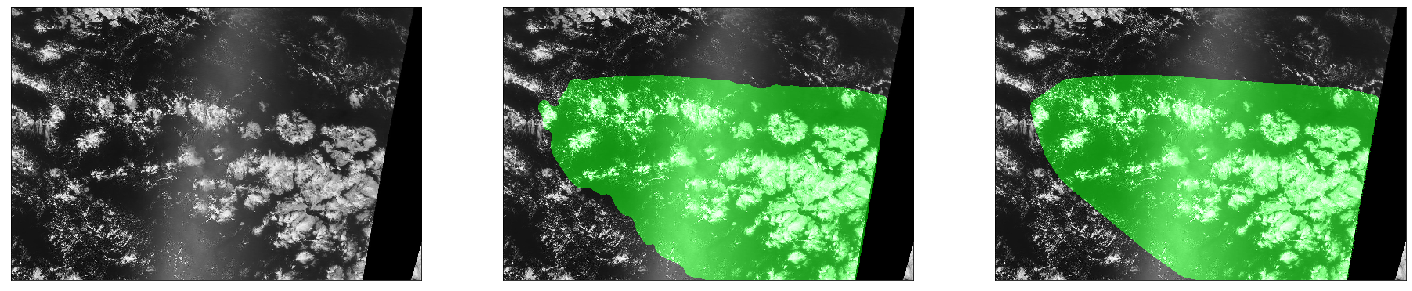

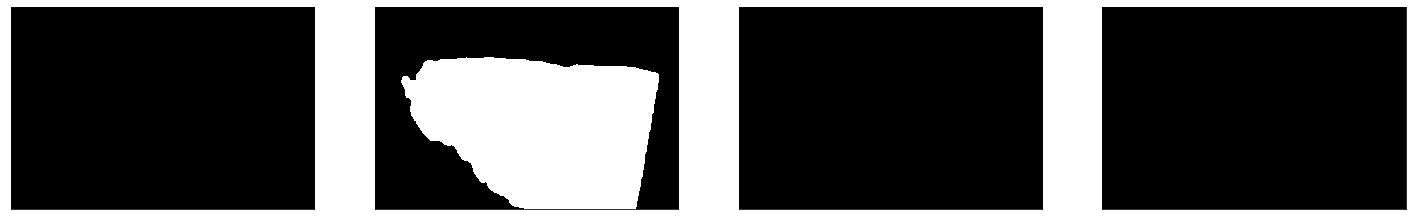

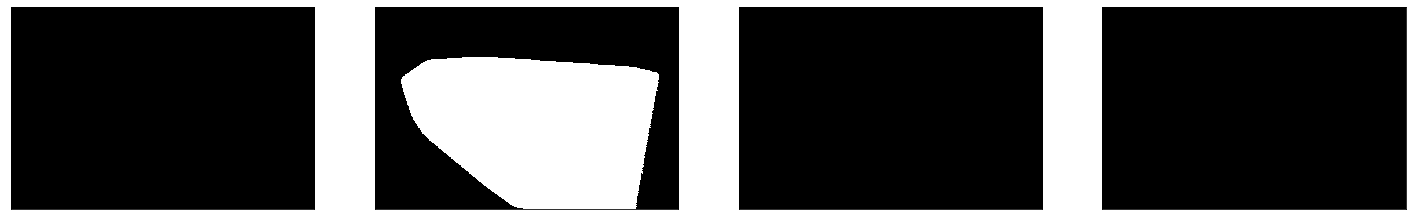

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/05fcce5.jpg
255.0 0.0
0.0 0.0
0 1
0.0 0.0
0.0 0.0


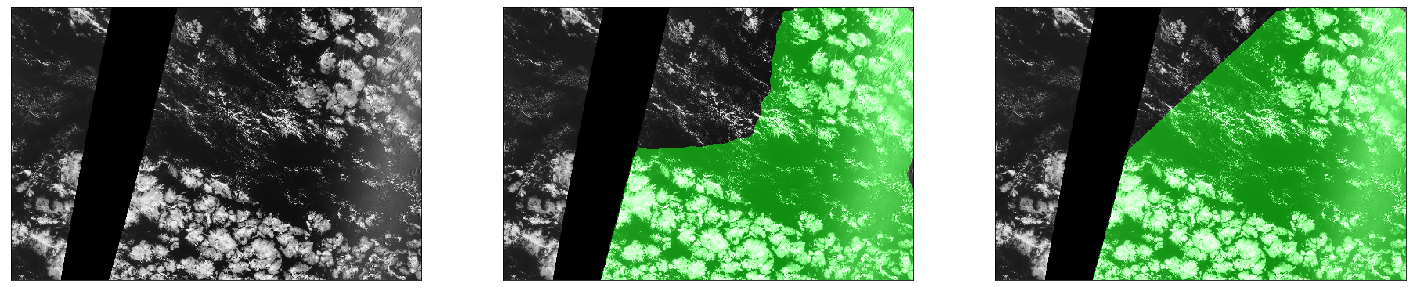

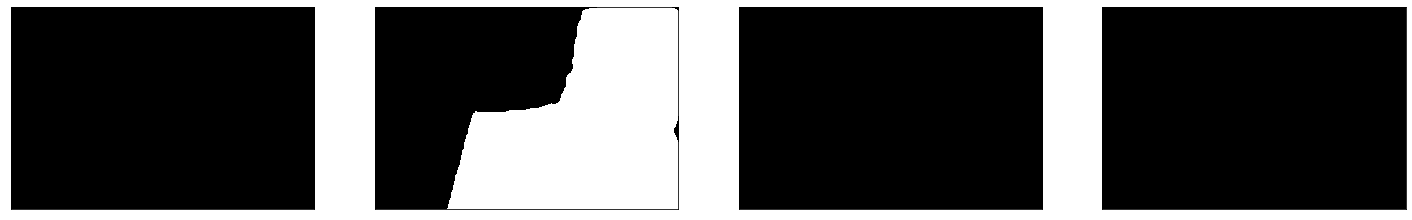

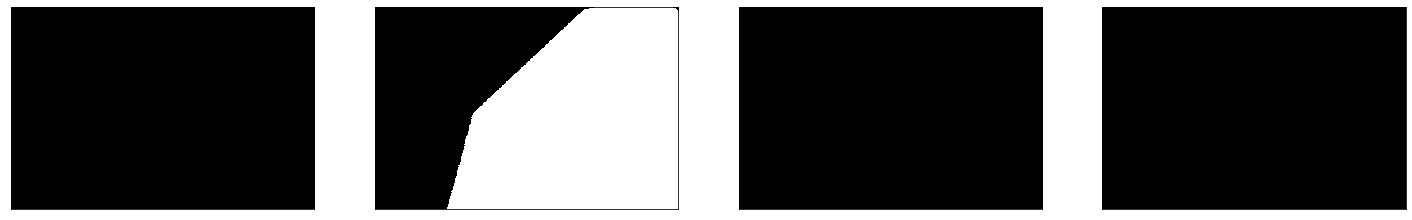

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/e949e4b.jpg
255.0 0.0
0 1
0.0 0.0
0 1
0.0 0.0


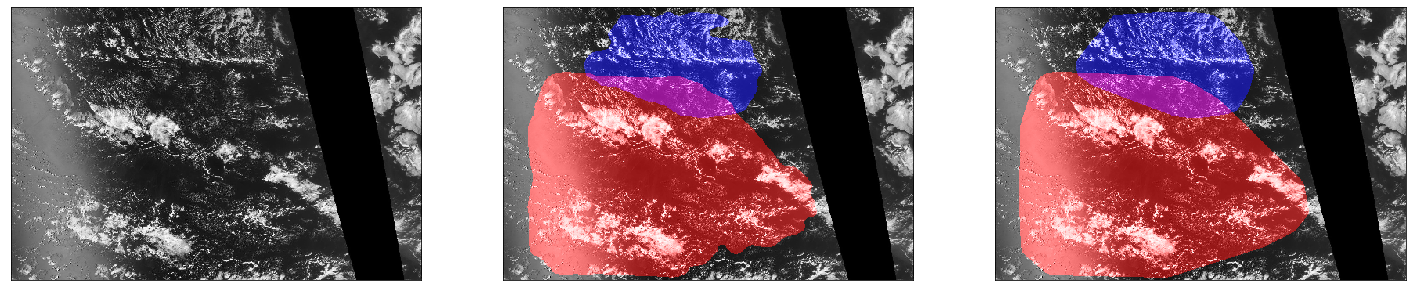

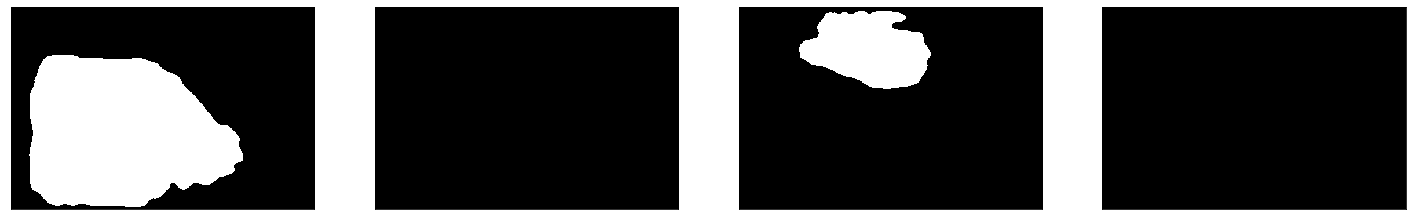

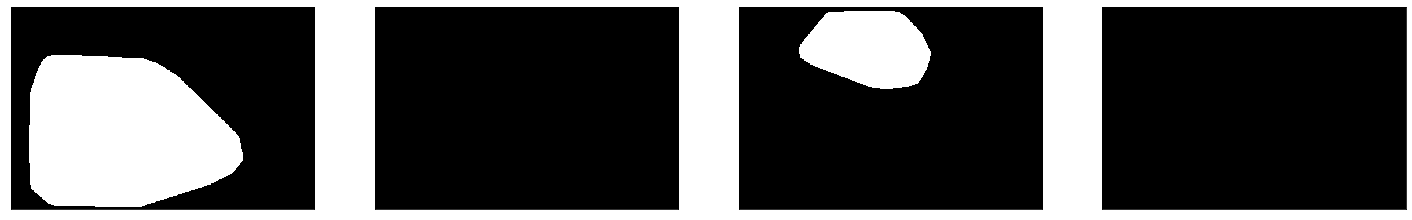

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/ce8df6b.jpg
255.0 0.0
0 1
0.0 0.0
0 1
0 1


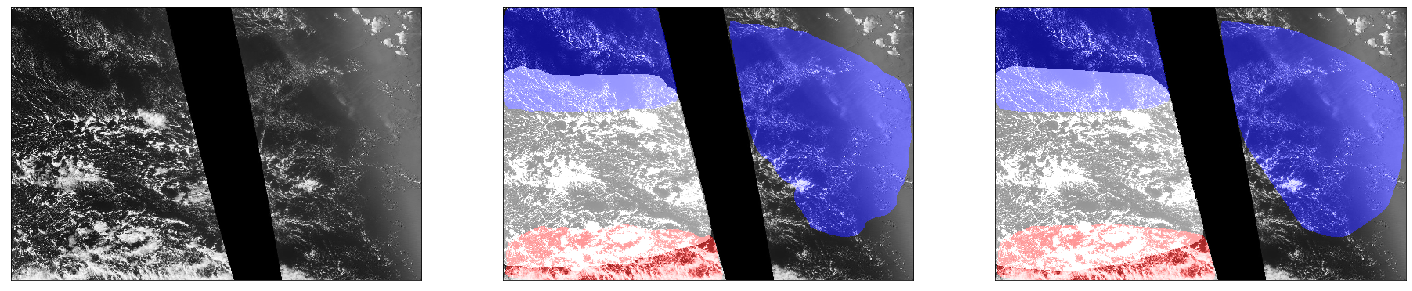

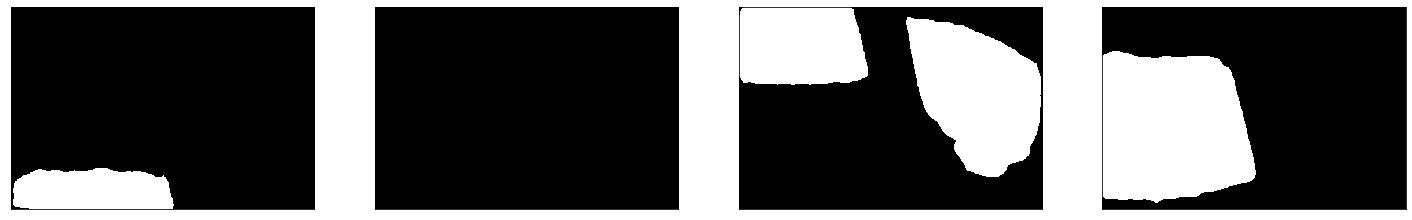

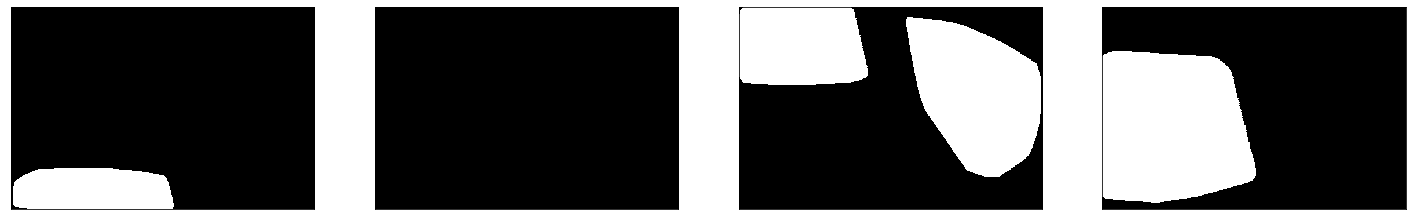

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/41be432.jpg
255.0 0.0
0 1
0.0 0.0
0 1
0.0 0.0


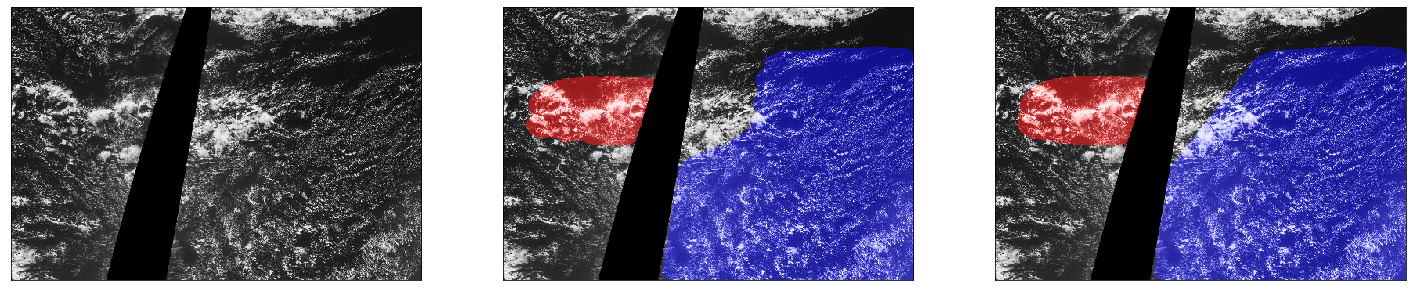

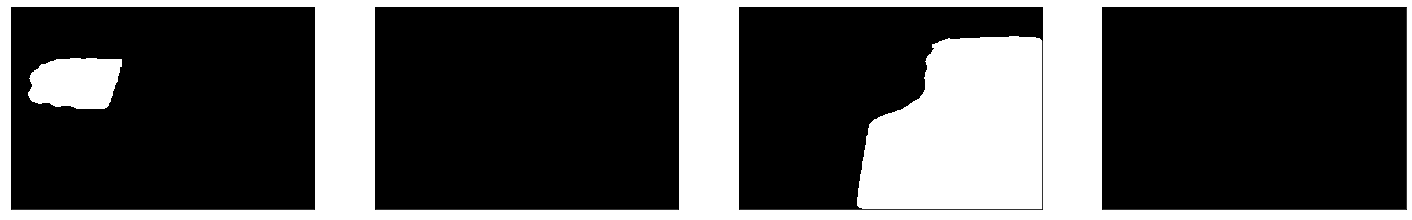

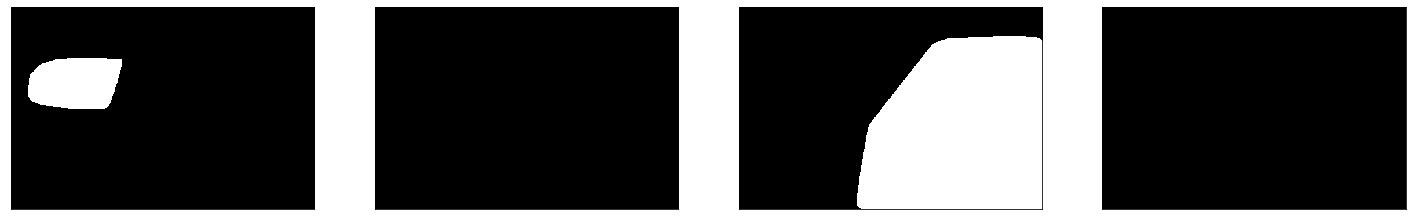

In [10]:
images_list = ['e0cacb5.jpg', '05fcce5.jpg', 'e949e4b.jpg', 'ce8df6b.jpg', '41be432.jpg'] #os.listdir(folder_images)
current_batch = images_list[0: NN]
print(current_batch)

for i, image_name in enumerate(current_batch):
    path = os.path.join(folder_images, image_name)
    print(path)
    img = open_image(path)
    print(img.max(), img.min())
    img = img/255.
    
    img2 = img.mean(axis=-1)
    img2 = np.stack([img2,img2,img2],axis=-1)
         
    img_mask=[]
    img_mask_convex=[]
    img_mask_convex_minsize=[]
    
    for class_id in range(4):
        img_mask.append(make_mask(sub, image_name + '_' + class_names[class_id],shape=(350,525)))
        print(img_mask[class_id].min(), img_mask[class_id].max())
        img_mask_convex.append(draw_convex_hull(img_mask[class_id].astype(np.uint8), mode=mode))
        img_mask_convex[class_id][img2[:,:,0]<=2/255.] = 0
        img_mask_convex_minsize.append(post_process_minsize(img_mask_convex[class_id], min_size[class_id]) )
    
    img3 = draw_masks(img2,img_mask)
    img4 = draw_masks(img2,img_mask_convex_minsize)
    show_Nimages([img2,img3,img4])
    show_Nimages(img_mask)
#     show_Nimages([img2]+img_mask_convex)
    show_Nimages(img_mask_convex_minsize)

## Approximated Polygon Shape (Douglas-Peucker algorithm) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['e0cacb5.jpg', '05fcce5.jpg', 'e949e4b.jpg', 'ce8df6b.jpg', '41be432.jpg']
test_images/e0cacb5.jpg
255.0 0.0
0.0 0.0
0 1
0.0 0.0
0.0 0.0


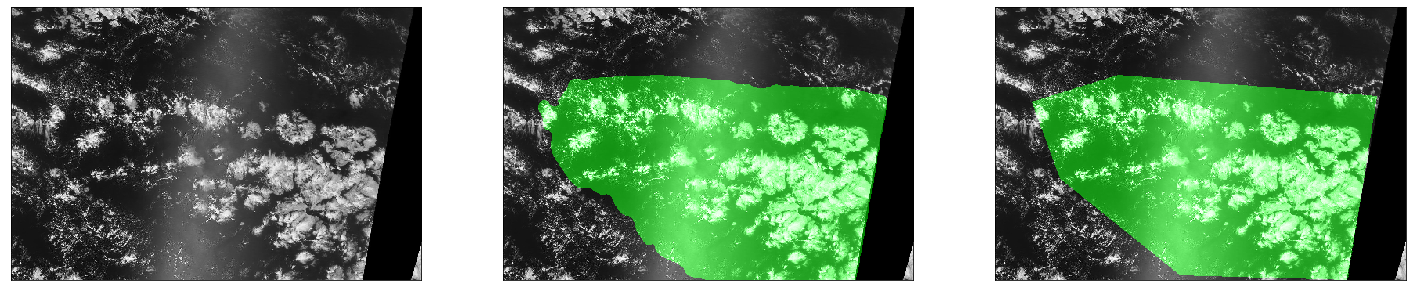

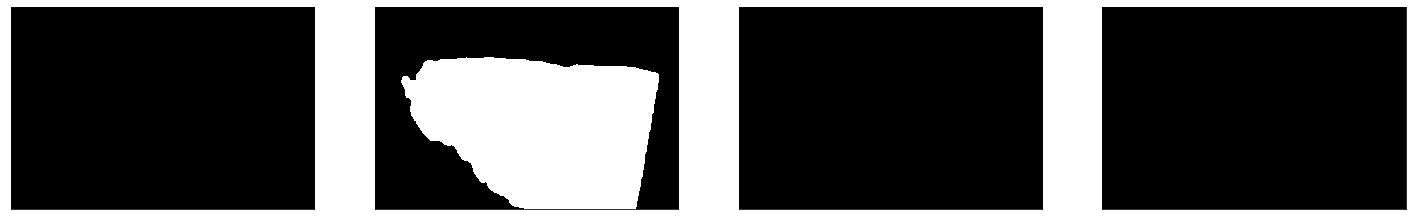

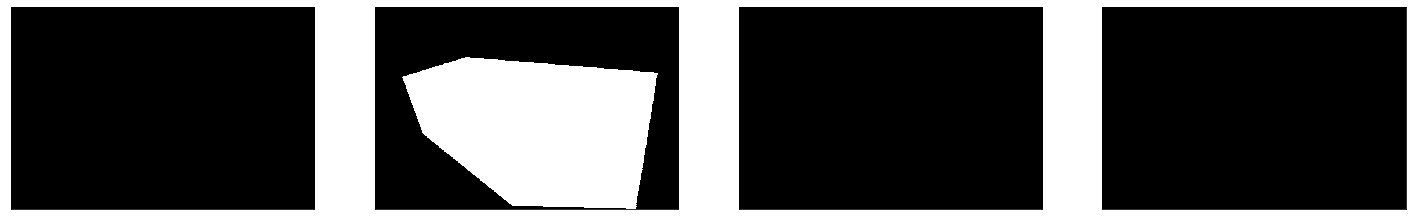

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/05fcce5.jpg
255.0 0.0
0.0 0.0
0 1
0.0 0.0
0.0 0.0


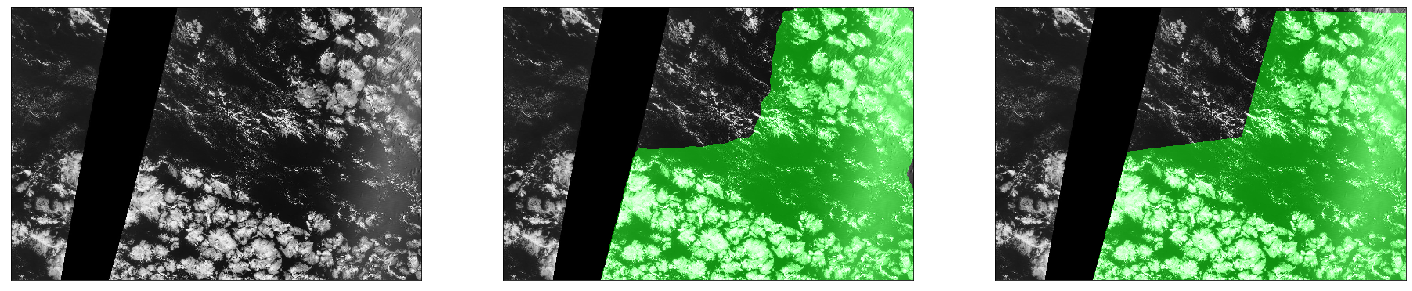

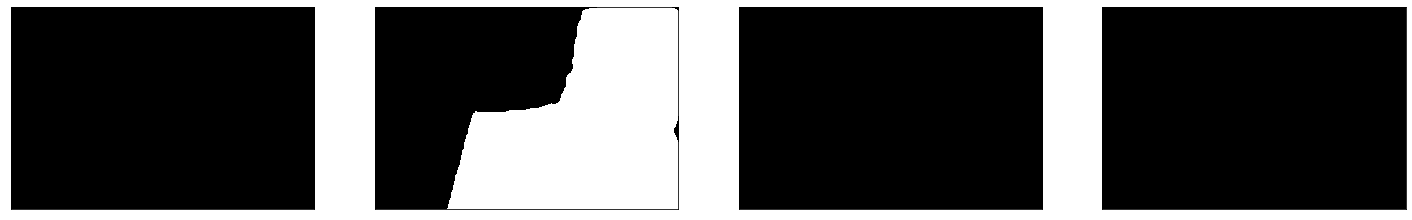

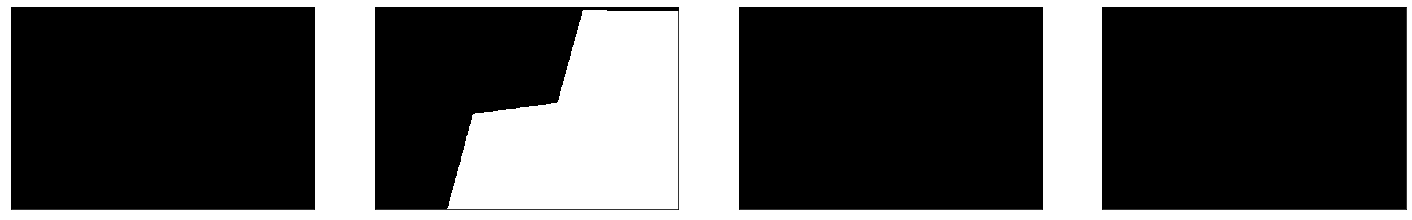

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/e949e4b.jpg
255.0 0.0
0 1
0.0 0.0
0 1
0.0 0.0


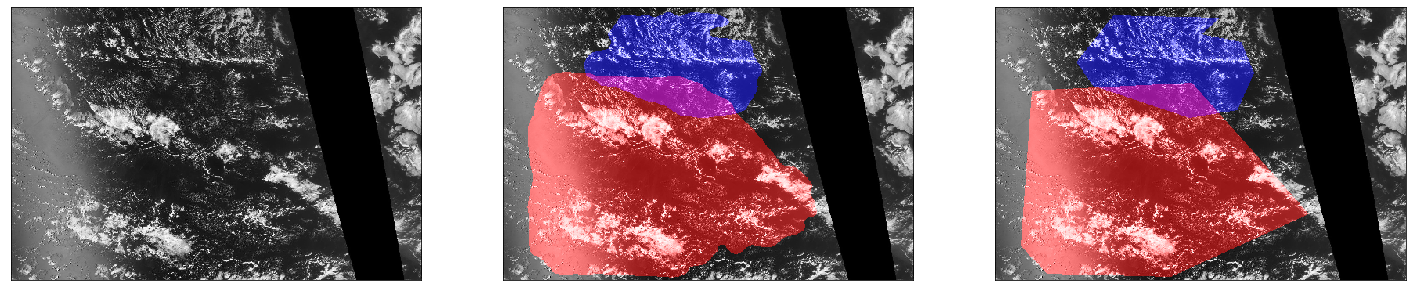

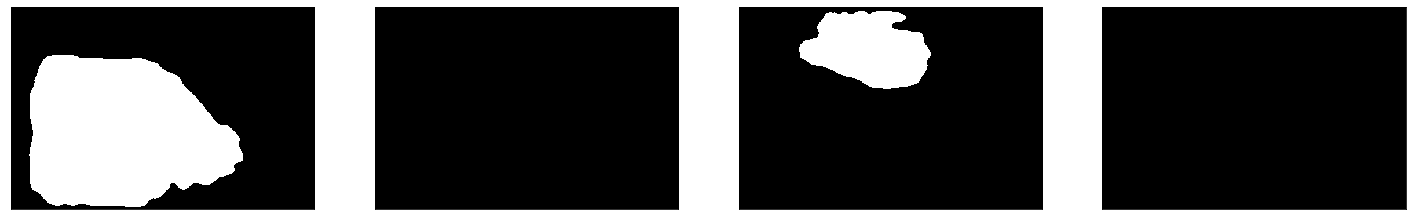

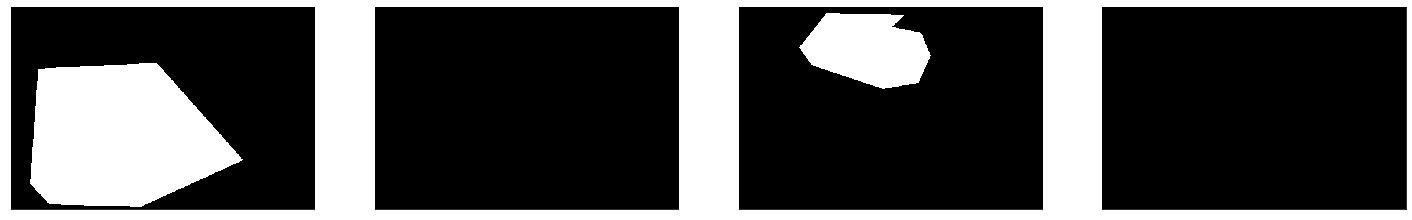

test_images/ce8df6b.jpg
255.0 0.0
0 1
0.0 0.0
0 1
0 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


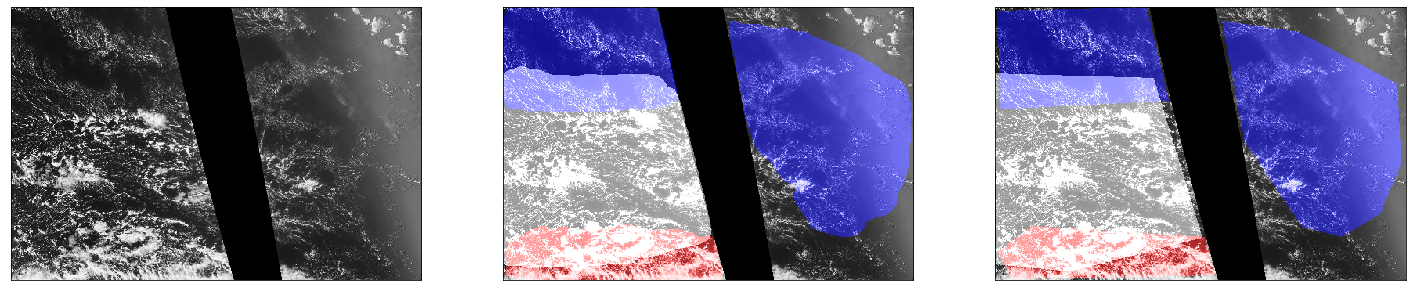

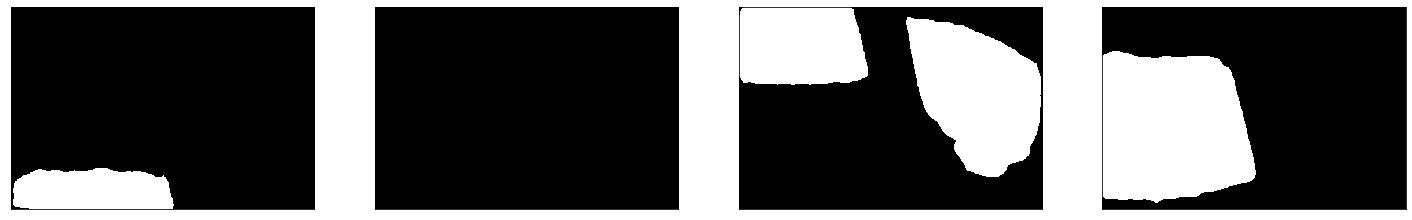

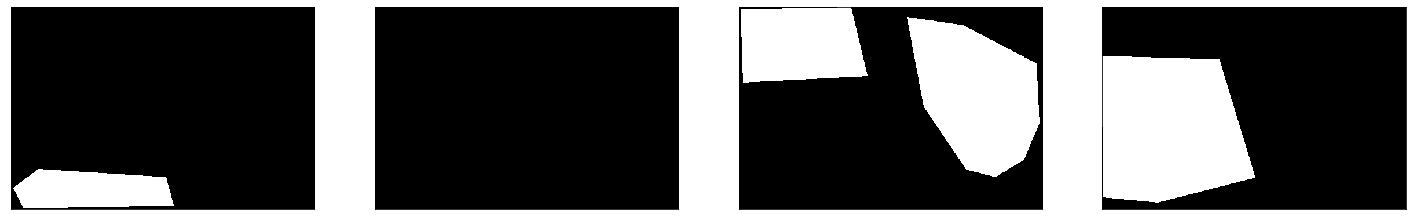

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/41be432.jpg
255.0 0.0
0 1
0.0 0.0
0 1
0.0 0.0


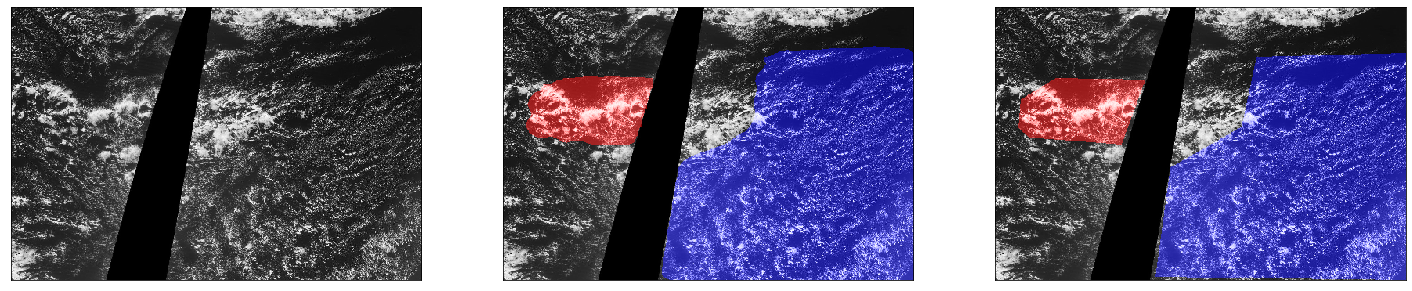

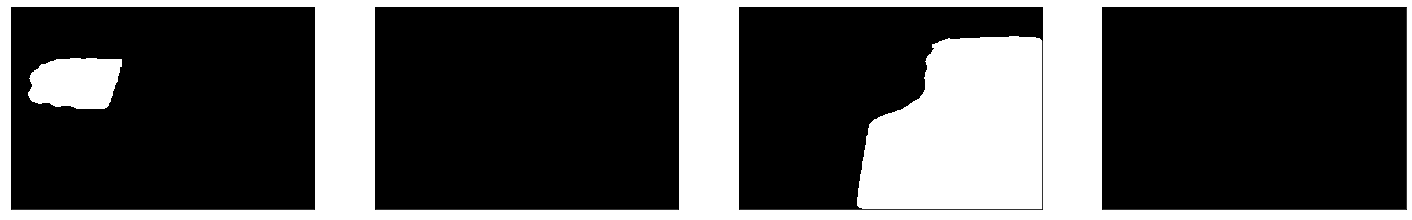

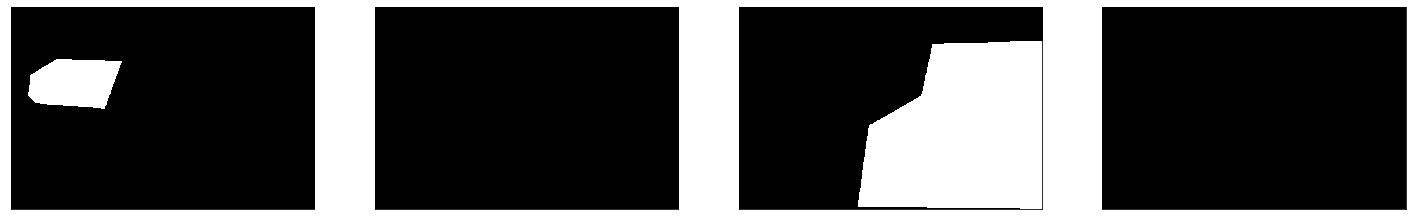

In [11]:
mode='approx' # choose from 'rect', 'min', 'convex' and 'approx'


test_imgs_folder = 'test_images/'
NN=5
folder_images=test_imgs_folder
images_list = ['e0cacb5.jpg', '05fcce5.jpg', 'e949e4b.jpg', 'ce8df6b.jpg', '41be432.jpg'] #os.listdir(folder_images)
current_batch = images_list[0: NN]
print(current_batch)

for i, image_name in enumerate(current_batch):
    path = os.path.join(folder_images, image_name)
    print(path)
    img = open_image(path) # use already-resized ryches' dataset
    print(img.max(), img.min())
    img = img/255.
    
    img2 = img.mean(axis=-1)
    img2 = np.stack([img2,img2,img2],axis=-1)
         
    img_mask=[]
    img_mask_convex=[]
    img_mask_convex_minsize=[]
    
    for class_id in range(4):
        img_mask.append(make_mask(sub, image_name + '_' + class_names[class_id],shape=(350,525)))
        print(img_mask[class_id].min(), img_mask[class_id].max())
        img_mask_convex.append(draw_convex_hull(img_mask[class_id].astype(np.uint8), mode=mode))
        img_mask_convex[class_id][img2[:,:,0]<=2/255.] = 0
        img_mask_convex_minsize.append(post_process_minsize(img_mask_convex[class_id], min_size[class_id]) )
    
    img3 = draw_masks(img2,img_mask)
    img4 = draw_masks(img2,img_mask_convex_minsize)
    show_Nimages([img2,img3,img4])
    show_Nimages(img_mask)
#     show_Nimages([img2]+img_mask_convex)
    show_Nimages(img_mask_convex_minsize)

## Post-processing

After preparing everything, we convert all masks to the selected-mode rectangle below.

In [12]:
model_class_names=['Fish', 'Flower', 'Gravel', 'Sugar']

In [ ]:
mode='convex' # choose from 'rect', 'min', 'convex' and 'approx'

img_label_list = []
enc_pixels_list = []
test_imgs = os.listdir(folder_images)
for test_img_i, test_img in enumerate(tqdm(test_imgs)):
    for class_i, class_name in enumerate(model_class_names):
        
        path = os.path.join(folder_images, test_img)
        img = open_image(path)
        img = img/255.
        img2 = img.mean(axis=-1)
        
        img_label_list.append(f'{test_img}_{class_name}')
        
        mask = make_mask(sub, test_img + '_' + class_name,shape=(350,525))
        if True:
        #if class_name == 'Flower' or class_name =='Sugar': # you can decide to post-process for some certain classes 
            mask = draw_convex_hull(mask.astype(np.uint8), mode=mode)
        mask[img2<=2/255.] = 0
        mask = post_process_minsize(mask, min_size[class_i])
        
        if mask.sum() == 0:
            enc_pixels_list.append(np.nan)
        else:
            mask = np.where(mask > 0.5, 1.0, 0.0)
            enc_pixels_list.append(mask2rle(mask))
            

In [ ]:
submission_df = pd.DataFrame({'Image_Label': img_label_list, 'EncodedPixels': enc_pixels_list})
submission_df.to_csv('convex_%s'%(FILE), index=None)

In [ ]:
sub_test=pd.read_csv('convex_%s'%(FILE))
sub_test.head(10)

In [ ]:
'''Uncomment this cell if you want to check that everything works fine'''
# NN=7

# folder_images=test_imgs_folder
# images_list = os.listdir(folder_images)
# current_batch = images_list[0: NN]
# print(current_batch)

# for i, image_name in enumerate(current_batch):
#     path = os.path.join(folder_images, image_name)
#     print(path)
#     img = cv2.imread(path).astype(np.float32) # use already-resized ryches' dataset
#     print(img.max(), img.min())
#     img = img/255.
    
#     img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img2 = np.stack([img2,img2,img2],axis=-1)
         
#     img_mask=[]
#     img_mask_convex=[]
#     for class_id in range(4):
#         img_mask.append(make_mask(sub_test, image_name + '_' + class_names[class_id],shape=(350,525)))
#         print(img_mask[class_id].min(), img_mask[class_id].max())
#         img_mask_convex.append(draw_convex_hull(img_mask[class_id].astype(np.uint8)))
#     show_Nimages([img2]+img_mask)
#     show_Nimages([img2]+img_mask_convex)